# Project 3
## Composed Encrypted Malicious Traffic Dataset for machine learning based encrypted malicious traffic analysis
### Dataset: bank sampled 9K

### Group Members
- Shedrach Ezenwali  300377414
- Bryan Rodriguez    300369955
- Hazel Ibasco       300366644
- Nathaniel Pearson  300387657

____

____

## Library-import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from datetime import datetime as dt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
df = pd.read_csv("./Dataset/Project_Dataset_small.csv")

In [3]:
## A look of the data set
df.head()

,session,Flag_of_packets,Traffic_sequence,Payload_ratio,Length_of_IP_packets,Length_of_TCP_payload,Length_of_TCP_packet_header,Length_of_IP_packet_header,TCP_windows_size_value,Length_of_TCP_segment(packet),...,std_backward_pkt_length,duration_forward,duration_back,mean_of_backward_IP_header,mean_of_forward_IP_header,total_payload_per_session,IPratio,Goodput,source_IP_address,Destination_IP_address
0,36921,16,1726605254,0.000000,40,0,20,20,256,20,...,2612.754597,73.926902,73.926820,20.0,20.0,46460.0,220.000000,70.495085,172.16.0.1,192.168.10.50
1,70905,24,111406979,0.422222,90,38,32,20,349,70,...,652.289643,23.073098,23.085064,20.0,20.0,1847669.0,28.269231,4594.488163,192.168.1.191,172.217.23.227
2,16501,24,1708705887,0.633028,109,69,20,20,15544,89,...,494.028050,0.624303,0.310843,20.0,20.0,5206.0,33.000000,70.015643,10.42.0.151,198.11.189.2
3,43411,16,3715465867,0.973333,1500,1460,20,20,1892,1480,...,571.420643,3.462844,3.463654,20.0,20.0,15827.0,48.925000,152.105082,192.168.10.15,31.172.81.159
4,10855,24,2844819149,0.818182,286,234,32,20,939,266,...,338.609370,0.115753,0.126025,20.0,20.0,86828.0,28.846154,182.869865,10.42.0.42,104.97.137.75


In [4]:
## Let's get general information about the data, the shape and also the data type

def get_data_description(df)->None:
    '''Take a dataframe and prints out a consise 
    description based on the data shape'''
    rows,cols = df.shape

    print(f'We have {rows} rows and {cols} columns in the data set')

get_data_description(df)



We have 10476 rows and 113 columns in the data set


In [5]:
## Checking of the data type of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10476 entries, 0 to 10475
Columns: 113 entries, session to Destination_IP_address
dtypes: float64(97), int64(14), object(2)
memory usage: 9.0+ MB


In [6]:
## Getting the percentage of missing values in each column

def check_cols_with_null(df):
    '''Gets  dataframe and prints out percentage of missing values in each column'''
    print(    df.shape)
    for col in df.columns:
        print(f'{col}: {format((df[col].isnull().sum()/df.shape[0])*100,".0f")}%')

check_cols_with_null(df)

(10476, 113)
session: 0%
Flag_of_packets: 0%
Traffic_sequence: 0%
Payload_ratio: 0%
Length_of_IP_packets: 0%
Length_of_TCP_payload: 0%
Length_of_TCP_packet_header: 0%
Length_of_IP_packet_header: 0%
TCP_windows_size_value: 0%
Length_of_TCP_segment(packet): 0%
Time_difference_between_packets_per_session: 0%
Change_values_of_TCP_windows_length_per_session: 0%
Interval_of_arrival_time_of_forward_traffic: 0%
Interval_of_arrival_time_of_backward_traffic: 0%
Time_to_live: 0%
Ratio_to_previous_packets_in_each_session: 0%
Total_length_of_IP_packet_per_session: 0%
Total_Time_to_live_per_session: 0%
The_times_of_change_of_TCP_windows_length: 0%
The_times_of_change_of_payload_per_session: 0%
Total_length_of_forward_payload: 0%
Total_length_of_backward_payload: 0%
Total_length_of_forward_IP_header: 0%
Total_length_of_backward_IP_header: 0%
Total_length_of_forward_TCP_header: 0%
Total_length_of_backward_TCP_header: 0%
Total_length_of_forward_IP_packets: 0%
Total_length_of_backward_IP_packets: 0%
flo

#### Categorical data such as source_IP_address and Destination_IP_address are not relevant.

In [7]:
# Removing categorical variables that are not considered important for the model 
df.drop(["source_IP_address","Destination_IP_address"],axis=1,inplace=True)

## Handling-non_valid-column-names

In [8]:
#columns to rename and their corresponding new names

columns_map = {
    "flow duration":"flow_duration"
}

df.rename(columns=columns_map,inplace = True)

## Creating-dummy-variables-for-each-categorical-feature

In [9]:
# Identify categorical features
categorical_columns = df.select_dtypes('object').columns

# Create dummy variables for each categorical feature
for column in categorical_columns:
    # Create dummy variables with a prefix related to the original column name
    dummies = pd.get_dummies(df[column], prefix=column, drop_first=True)
    
    # Rename columns using lambda to replace hyphen '-' with underscore '_'
    dummies.columns = dummies.columns.map(lambda x: x.replace('-', '_'))
    
    # Concatenate the dummy variables to the original DataFrame
    df = pd.concat([df, dummies], axis=1)
    
# Drop the original categorical columns
df = df.drop(categorical_columns, axis=1)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10476 entries, 0 to 10475
Columns: 111 entries, session to Goodput
dtypes: float64(97), int64(14)
memory usage: 8.9 MB


## Exploratory analysis

### Searching best correlation 

In [11]:
df.corr()

,session,Flag_of_packets,Traffic_sequence,Payload_ratio,Length_of_IP_packets,Length_of_TCP_payload,Length_of_TCP_packet_header,Length_of_IP_packet_header,TCP_windows_size_value,Length_of_TCP_segment(packet),...,Source_port,std_forward_pkt_length,std_backward_pkt_length,duration_forward,duration_back,mean_of_backward_IP_header,mean_of_forward_IP_header,total_payload_per_session,IPratio,Goodput
session,1.000000,0.059464,-0.037602,0.162769,-0.004941,-0.005851,0.142884,NaN,0.139968,-0.004941,...,-0.248161,0.222545,-0.111225,0.144354,0.140728,-0.001890,NaN,0.019794,-0.169990,-0.054518
Flag_of_packets,0.059464,1.000000,0.002789,0.150440,-0.292459,-0.292334,-0.004379,NaN,0.002694,-0.292459,...,-0.164167,0.048958,-0.383781,0.055365,0.048452,-0.006654,NaN,0.006172,-0.411071,-0.026558
Traffic_sequence,-0.037602,0.002789,1.000000,-0.033481,-0.011656,-0.012062,0.064371,NaN,-0.143630,-0.011656,...,-0.040963,0.012430,0.031754,0.019184,0.019051,-0.000954,NaN,-0.006648,0.031787,-0.011798
Payload_ratio,0.162769,0.150440,-0.033481,1.000000,0.522375,0.521957,0.038307,NaN,0.086147,0.522375,...,-0.107874,0.241276,-0.571227,0.071431,0.064390,-0.004363,NaN,0.006813,-0.595862,0.072126
Length_of_IP_packets,-0.004941,-0.292459,-0.011656,0.522375,1.000000,0.999980,-0.048959,NaN,-0.031455,1.000000,...,0.071739,0.062577,0.066651,-0.032581,-0.030067,0.004419,NaN,-0.001637,0.074318,0.050442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mean_of_backward_IP_header,-0.001890,-0.006654,-0.000954,-0.004363,0.004419,0.004357,0.009527,NaN,0.005247,0.004419,...,0.016757,-0.014598,0.009431,0.002651,0.002601,1.000000,NaN,0.000177,0.003238,0.001505
mean_of_forward_IP_header,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_payload_per_session,0.019794,0.006172,-0.006648,0.006813,-0.001637,-0.001736,0.015614,NaN,-0.006204,-0.001637,...,0.005043,0.015254,-0.012890,-0.004811,-0.004716,0.000177,NaN,1.000000,0.001105,0.018877
IPratio,-0.169990,-0.411071,0.031787,-0.595862,0.074318,0.075752,-0.228673,NaN,-0.127978,0.074318,...,0.297500,-0.258909,0.899821,-0.095984,-0.086327,0.003238,NaN,0.001105,1.000000,-0.042925


In [12]:
correlation_matrix = df.corr()

In [13]:
# Example: Find pairs with correlation above 0.7
strong_correlations = correlation_matrix[abs(correlation_matrix) > 0.7]

In [14]:
strong_correlations

,session,Flag_of_packets,Traffic_sequence,Payload_ratio,Length_of_IP_packets,Length_of_TCP_payload,Length_of_TCP_packet_header,Length_of_IP_packet_header,TCP_windows_size_value,Length_of_TCP_segment(packet),...,Source_port,std_forward_pkt_length,std_backward_pkt_length,duration_forward,duration_back,mean_of_backward_IP_header,mean_of_forward_IP_header,total_payload_per_session,IPratio,Goodput
session,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Flag_of_packets,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Traffic_sequence,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Payload_ratio,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Length_of_IP_packets,NaN,NaN,NaN,NaN,1.0,0.99998,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mean_of_backward_IP_header,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
mean_of_forward_IP_header,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_payload_per_session,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
IPratio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.899821,NaN,NaN,NaN,NaN,NaN,1.0,NaN


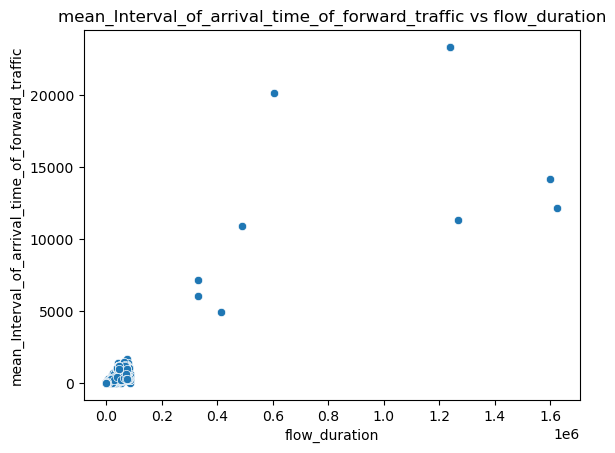

In [15]:
## let's see data

sns.scatterplot(x=df.flow_duration,y=df.mean_Interval_of_arrival_time_of_forward_traffic)

plt.title("mean_Interval_of_arrival_time_of_forward_traffic vs flow_duration")

plt.show()

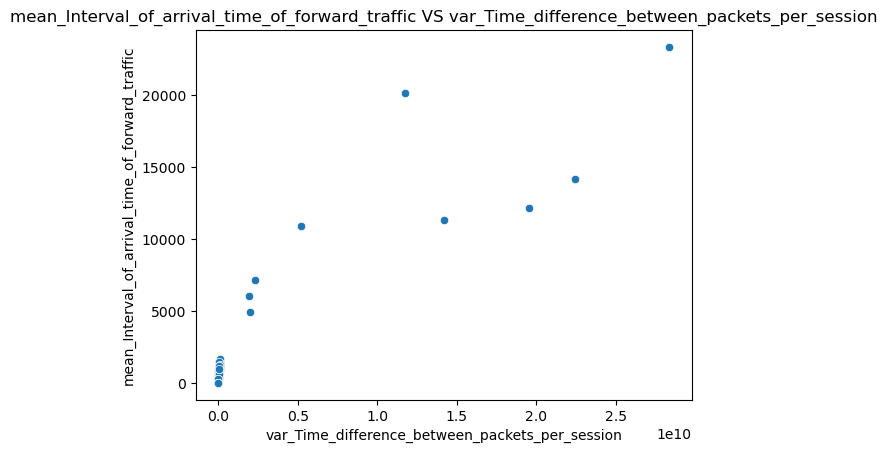

In [16]:
## let's see data

sns.scatterplot(x=df.var_Time_difference_between_packets_per_session,y=df.mean_Interval_of_arrival_time_of_forward_traffic)

plt.title("mean_Interval_of_arrival_time_of_forward_traffic VS var_Time_difference_between_packets_per_session")

plt.show()

____

## Feature-Selection-and-Scaling

#### As we have a type of high-dimensional data sets and they are all used for the creation of Machine Learning models, it can cause:

          * The additional features act as noise for which the Machine Learning model can perform extremely poorly.
          * The model takes longer to train.
          * Allocation of unnecessary resources for these features.

For all this, feature selection must be implemented in Machine Learning projects.

In [17]:
X_main = df.drop('label', axis=1)  
Y_main = df['label']

#split the dataset
X_train_main, X_test_main, Y_train_main, Y_test_main = train_test_split(X_main,Y_main, test_size=0.2, random_state=42)

In [18]:
# Logistic Regression
lr_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection',SelectFromModel(estimator = LogisticRegression(max_iter=5000))),
])

# Linear SVM
svm_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectFromModel(estimator = LinearSVC(C=0.001, max_iter=5000,dual=True)))
])

# SelectKBest
kbest_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(mutual_info_classif, k='all')),
])

# Fit the models and get selected features

# Logistic Regression
lr_pipe.fit(X_train_main, Y_train_main)
lr_selected_features = X_main.columns[lr_pipe.named_steps['feature_selection'].get_support()]

# Linear SVM
svm_pipe.fit(X_train_main, Y_train_main)
svm_selected_features = X_main.columns[svm_pipe.named_steps['feature_selection'].get_support()]

# SelectKBest
kbest_pipe.fit(X_train_main, Y_train_main)
kbest_selected_features = X_main.columns[kbest_pipe.named_steps['feature_selection'].get_support(indices=True)]

# Choose the method with the least number of features
selected_method = min([(lr_selected_features, 'LogisticRegression'),
                      (svm_selected_features, 'LinearSVM'),
                      (kbest_selected_features, 'SelectKBest')], key=lambda x: len(x[0]))

selected_features, method_name = selected_method
method_name
print(f"{method_name} is the best method with {len(selected_features)} features")

LogisticRegression is the best method with 35 features


In [19]:
selected_features

Index(['session', 'Length_of_TCP_packet_header',
       'Interval_of_arrival_time_of_backward_traffic', 'flow_duration',
       'median_Length_of_IP_packets', 'max_Length_of_IP_packets',
       'var_Length_of_IP_packets', 'max_Length_of_TCP_payload',
       'var_Length_of_TCP_payload', 'median_Length_of_TCP_packet_header',
       'max_Length_of_TCP_packet_header', 'std_Length_of_TCP_packet_header',
       'mean_TCP_windows_size_value', 'max_TCP_windows_size_value',
       'std_TCP_windows_size_value', 'var_TCP_windows_size_value',
       'median_Length_of_TCP_segment(packet)',
       'max_Length_of_TCP_segment(packet)',
       'var_Length_of_TCP_segment(packet)',
       'std_Time_difference_between_packets_per_session',
       'var_Time_difference_between_packets_per_session',
       'mean_Change_values_of_TCP_windows_length_per_session',
       'max_Change_values_of_TCP_windows_length_per_session',
       'std_Change_values_of_TCP_windows_length_per_session',
       'var_Change_values

In [20]:
# selected features dataframe
selected_features_df = df[selected_features]
selected_features_df['label'] = Y_main
selected_features_df.head(3)

C:\Users\Bryan Rodriguez\AppData\Local\Temp\ipykernel_8168\457782043.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_features_df['label'] = Y_main


,session,Length_of_TCP_packet_header,Interval_of_arrival_time_of_backward_traffic,flow_duration,median_Length_of_IP_packets,max_Length_of_IP_packets,var_Length_of_IP_packets,max_Length_of_TCP_payload,var_Length_of_TCP_payload,median_Length_of_TCP_packet_header,...,std_Interval_of_arrival_time_of_forward_traffic,var_Interval_of_arrival_time_of_forward_traffic,mean_Interval_of_arrival_time_of_backward_traffic,std_Interval_of_arrival_time_of_backward_traffic,var_Interval_of_arrival_time_of_backward_traffic,mean_time_to_live,std_time_to_live,std_backward_pkt_length,IPratio,label
0,36921,20,0.000000,689.920439,40.0,8800.0,4.147591e+06,8760.0,4.150871e+06,20.0,...,70.469106,70.469106,13.087891,71.864749,5164.542192,102.153846,30.163264,2612.754597,220.000000,1
1,70905,32,0.021637,427.644806,1470.0,1470.0,4.540634e+05,1418.0,4.547751e+05,32.0,...,2.747460,2.747460,0.191420,2.746800,7.544911,58.438227,3.683055,652.289643,28.269231,0
2,16501,20,0.000048,91.493840,78.0,1320.0,1.071878e+05,1280.0,1.076574e+05,20.0,...,0.104040,0.104040,3.146667,16.462930,271.028051,53.551724,11.059670,494.028050,33.000000,0


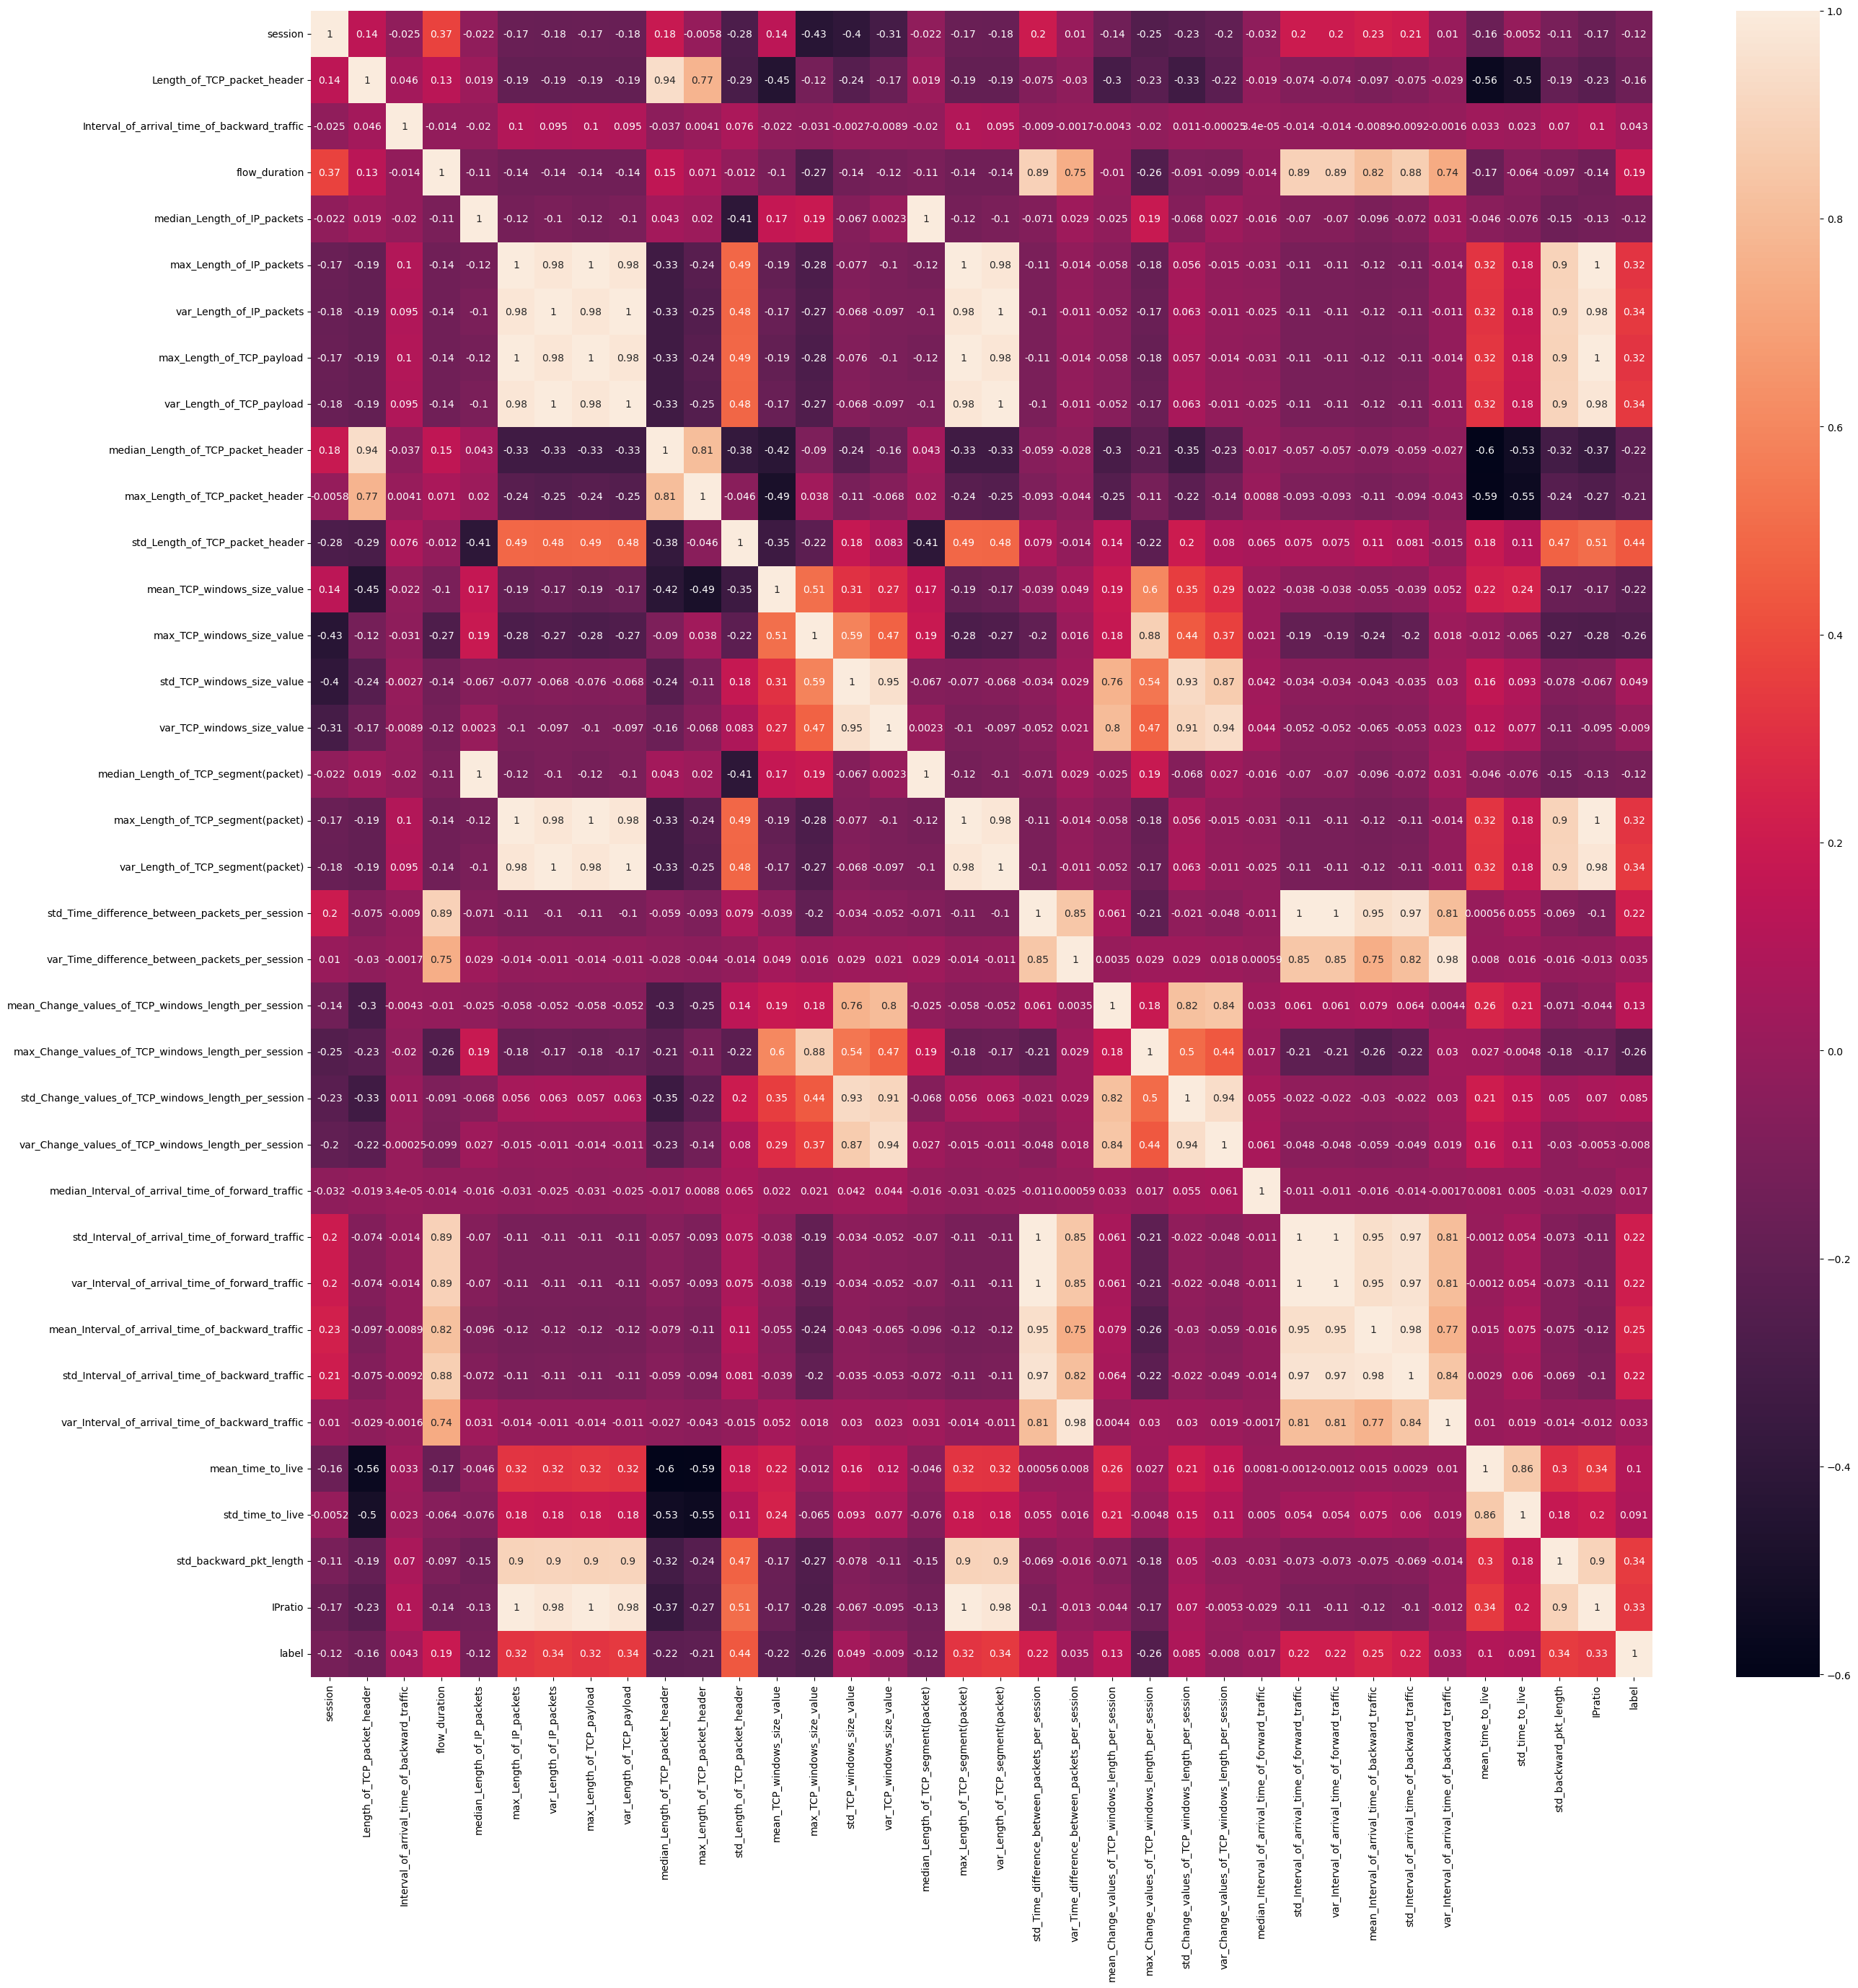

In [21]:
corr = selected_features_df.corr()

plt.figure(figsize=(30,30))
sns.heatmap(corr,annot=True)

plt.show()

___

### Scaling selected features

In [22]:
# Example: Predict 'label' using other features
##Separate features (X_selected) and the target variable (Y_selected):
X_selected = df.drop('label', axis=1)  # Assuming 'label' is the target variable
Y_selected = df['label']

In [23]:
#Split the dataset into training and testing sets:
X_train_selected, X_test_selected, \
y_train_selected, y_test_selected = train_test_split(X_selected, Y_selected, test_size=0.2, random_state=42)

#### Standardize the features

In [24]:
# For simplicity, I'll use StandardScaler to standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

____

### Model Training and Evaluation:

In [25]:
##Training machine learning model (Random Forest as per your previous context):
model = RandomForestClassifier(random_state=42)
model.fit(X_train_scaled, y_train_selected)

RandomForestClassifier(random_state=42)

In [33]:
##Make predictions and evaluate the model:
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test_selected, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9899809160305344


### Classification Report 

In [32]:
print(classification_report(y_test_selected, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1065
           1       0.99      0.99      0.99      1031

    accuracy                           0.99      2096
   macro avg       0.99      0.99      0.99      2096
weighted avg       0.99      0.99      0.99      2096



In [27]:
confusion_mat = confusion_matrix(y_test_selected, y_pred)

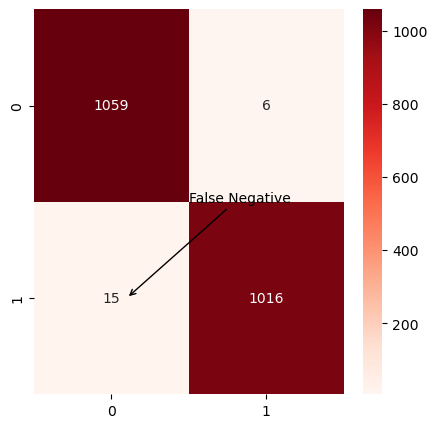

In [28]:
plt.figure(figsize = (5,5))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.annotate('False Negative', xy=(0.6, 1.5), xytext=(1, 1),
             arrowprops=dict(facecolor='black', arrowstyle='->'))
sns.heatmap(confusion_mat,cmap="Reds",annot=True,fmt="d")

plt.show()

# Member Contribution 

| Evaluator/Evaluatee |Shedrach Ezenwali   | Bryan Rodriguez | Hazel Ibasco | Nathaniel Pearson|
|------|------| ------| ------| ------|
| Shedrach Ezenwali | - |  |  |  |
| Bryan Rodriguez |  | - | | | 
| Hazel Ibasco |  |  | -  | |
| Nathaniel Pearson | | | | - |

____